In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from indoorplants.analysis import exploratory
from indoorplants.validation import crossvalidate, curves

from LinearRegressor import LinearRegressor


In [2]:
%matplotlib inline

# `Ridge Regression`

### ------------------------------------------------------------------------------------------------

# Overview 

 **Goal**: predict the behavior of a continuous _endogenous_ variable given its corresponding _exogenous_ variables, under the constraint that we are penalizing based on coefficient magnitudes when solving for said coefficients. This setup allows for models that are less prone to over-fitting than simple OLS models are.
 
 **Model**: $y = X{\beta} + {\epsilon}$

**Terms**:
- $y$: vector of endogenous values
- $X$: matrix of exogenous values
- $\beta$: vector of coefficients for exogenous variables
- $\epsilon$: a representation of the random errors or fluctuations around the predicted line or plane

**Functionality**:
- $y$ is the result of taking the matrix product of $\beta$ and $X$
- i.e. each row in $y$ is the sum of the products, for that row, of each value of $X$ with its corresponding $\beta$

**Basic example**:
- *endogenous*: price of an apartment
- *exogenous*: square footage (1), number of rooms (2)
- $y = \beta_{0} + \beta_{1} * X_{1} + \beta_{2} * X_{2} + \epsilon$
- i.e. $constant + coefficient_{1} * area + coefficient_{2} * rooms$

### ------------------------------------------------------------------------------------------------

# Tikhonov regularization

$\displaystyle \min _{\beta }\,(\mathbf {y} -\mathbf {X} \beta )^{\mathsf {T}}(\mathbf {y} -\mathbf {X} \beta )+\lambda (\beta ^{\mathsf {T}}\beta -c)$

$\displaystyle {\hat {\beta }}_{R}=(\mathbf {X} ^{\mathsf {T}}\mathbf {X} +\lambda \mathbf {I} )^{-1}\mathbf {X} ^{\mathsf {T}}\mathbf {y}$

### ------------------------------------------------------------------------------------------------

# Parameter Estimation - OLS

**Goal**: given $X$ and $y$, find $\beta$

**Method**: there exist many ways to reach our goal - we will start with Ordinary Least Squares (OLS)

(notes written with support from [Wikipedia](https://en.wikipedia.org/wiki/Ordinary_least_squares) and [ESL](http://web.stanford.edu/~hastie/ElemStatLearn/))

### Background

- to measure the distance between a response and a predicted response, one can take the difference between the two values
- this would be written as, for the $i^{th}$ data point, $y_{i} - {X_{i}}\beta$ (note that $X_{i}$ is a row of $X$), and is referred to as the _residual_ for this data point

### Overall model fit

- summing the squares of all residuals provides a measure of overall model fit
- sum of squared residuals: $\sum_{i=1}^{n}(y_{i} - \sum_{j=1}^{p}{X_{i, j}\beta_{j})}^{2} = {(y-X\beta)}^{T}(y-X\beta)$

### Estimate Beta

- if we find the values of $\beta$ that minimize the sum of the squared residuals, we have found the model coefficients that provide the best fit
- to find the values of $\beta$ that minimize ${(y-X\beta)}^{T}(y-X\beta)$ we need to first differentiate with respect to $\beta$, yielding a first derivative $-2X^{T}(y - X\beta)$
- if we set that first derivate equal to 0, $X^{T}(y - X\beta) = 0$, we can, making some assumptions, solve to:

$$\hat\beta = (X^{T}X)^{-1}X^{T}y$$

- see more on the derivation of OLS regression [here](https://are.berkeley.edu/courses/EEP118/current/derive_ols.pdf)

### Evaluation

- a commonly used metric for fit assessment is that of $R^{2}$
- this is the ratio of the variance of $\hat{y}$ around the mean of $y$, $\bar{y}$, to the variance of $y$, i.e. the ratio of "explained" to "total" variance of $y$
- which is written as $\large\frac{\sum(\hat{y} - \bar{y})^{2}}{\sum(y - \bar{y})^{2}}$
- useful use of this metric requires the model to include a constant, or $\beta_{0}$, term, in which case 0 < $R^{2}$ < 1, with closer to 1 being better

### ------------------------------------------------------------------------------------------------

# Implementation

In [3]:
class RidgeRegressor:
    """Ridge Regression class, built for NumPy arrays. 
    Fits using lin alg. Always supplies a constant coefficient.
    Very unstable!
    
    (subbing in `alpha` for `lambda` due to the latter's protected status)
    """
    
    def __init__(self, alpha=1):
        self.B = None
        self.alpha = alpha
        self._estimator_type = "regressor"
        
    
    def fit(self, X, y):
        for_coeff = np.ones((X.shape[0], 1))
        X = np.hstack((X, for_coeff))
        self.B = np.linalg.inv(X.T.dot(X) + self.alpha * np.identity(X.shape[1])).dot(X.T).dot(y)
        return self
    
    
    def predict(self, X):
        for_coeff = np.ones((X.shape[0], 1))
        X = np.hstack((X, for_coeff))
        return X.dot(self.B)

    
    def r_sqrd(self, X, y):
        y_hat = self.predict(X)
        y_bar = np.mean(y)
        explained = np.sum(np.power(y_hat - y_bar, 2))
        total = np.sum(np.power(y - y_bar, 2))
        return explained / total

### ------------------------------------------------------------------------------------------------

# Testing

## Test 1: Generate Fake Data

- with `Ridge`, we are looking to prevent overfitting
- overfitting can happen when a model is too tightly coupled to the sample of the data that it happens to be trained on
- so, to do this right, we need an idea of what the distribution of our population looks like
- then, we need to draw sub-samples that do not represent the population very well

In [4]:
X = np.array([[np.random.normal(loc=_, scale=(_ + 1)) for _ in range(100)] for _ in range(3)])

In [5]:
X = X.T

In [6]:
y = np.array([np.random.normal() for _ in range(100)])

In [7]:
# plt.figure(figsize=(11, 8))
# ax = plt.scatter(X[:, 0], y)
# plt.xlabel("X")
# plt.ylabel("y")
# t = plt.title("Semi-Random Data: X1")

In [8]:
# plt.figure(figsize=(11, 8))
# ax = plt.scatter(X[:, 1], y)
# plt.xlabel("X")
# plt.ylabel("y")
# t = plt.title("Semi-Random Data: X2")

In [9]:
# plt.figure(figsize=(11, 8))
# ax = plt.scatter(X[:, 2], y)
# plt.xlabel("X")
# plt.ylabel("y")
# t = plt.title("Semi-Random Data: X3")

In [10]:
ridge = RidgeRegressor()

In [11]:
ridge.fit(X,y)

In [12]:
y_hat = ridge.predict(X)

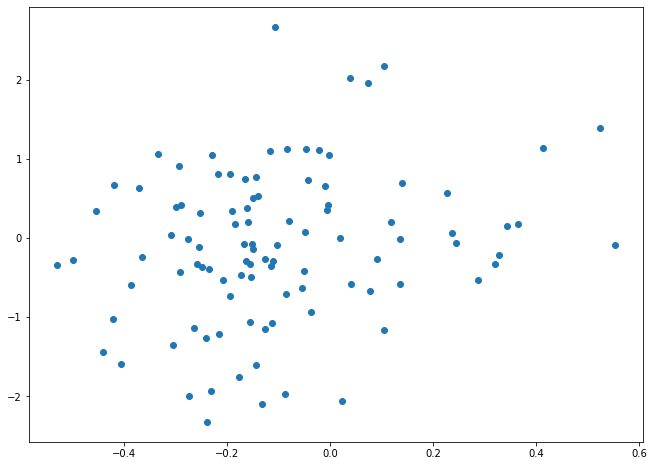

In [13]:
plt.figure(figsize=(11, 8))
ax = plt.scatter(y_hat, y)

In [14]:
ridge.r_sqrd(X, y)

0.050332317729521826

## Testing on sklearn ridge regression

In [15]:
clf = Ridge(alpha=1.0)
clf.fit(X, y)

Ridge()

In [16]:
y_hat2 = clf.predict(X)

In [17]:
clf.score(X,y)

0.05035649611655302

In [18]:
(y_hat - y_hat2).sum()

0.11044558632184717

## Test 2: Insurance Data
- Insurance data can be find [here](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv) and also at kaggle: [medical cost personal datasets](https://www.kaggle.com/mirichoi0218/insurance)
- Independent variables: `age`, `sex`, `bmi`, `children`,`smoker`,`region`
- Dependent variables: `charges`

In [19]:
url ="https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"

In [20]:
insurance_data = pd.read_csv(url)

In [21]:
insurance_data.shape

(1338, 7)

In [22]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Let's make a feature that depends on `bmi`

In [23]:
insurance_data["bmi_derivative"] = insurance_data.bmi**2 +10

### 1 Cleaning

In [24]:
insurance_data.duplicated().sum()

1

In [25]:
insurance_data = insurance_data.drop_duplicates()

In [26]:
insurance_data.duplicated().sum()

0

In [27]:
insurance_data.dtypes

age                 int64
sex                object
bmi               float64
children            int64
smoker             object
region             object
charges           float64
bmi_derivative    float64
dtype: object

In [28]:
insurance_data.isna().sum()

age               0
sex               0
bmi               0
children          0
smoker            0
region            0
charges           0
bmi_derivative    0
dtype: int64

### 2. Exploratory Data Analysis
#### 2.1 Age

In [29]:
insurance_data.age.describe()

count    1337.000000
mean       39.222139
std        14.044333
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

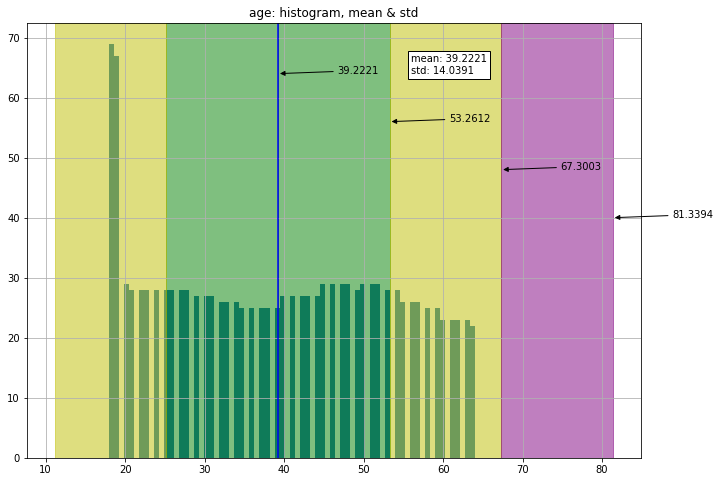

In [30]:
ax = exploratory.center_scale_plot(insurance_data.age, np.mean, np.std, bins=73)

**Notes:** The age in the insurance data range from 18 to 64.  The average age of the data set is 39.2. 

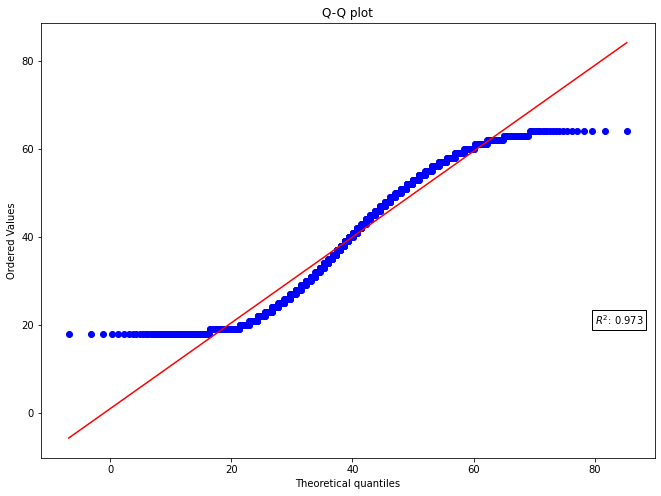

In [31]:
ax = exploratory.qq_plot(insurance_data.age)

**Notes:** The Q-Q plot shows that the age data is partially close to a normal distribution (quantile 20 to 60). However on both tiles. there are sharpe drops because the range of data are from 18 to 64.

#### 2.2 Sex

In [32]:
insurance_data.sex.value_counts()

male      675
female    662
Name: sex, dtype: int64

**Notes:** Male and female are equally distributed
- Check join dist target against categorical features.

In [33]:
grouped = insurance_data[["sex","charges"]].groupby("sex").agg(['mean','std'])

In [34]:
grouped

charges              
                mean           std
sex                               
female  12569.578844  11128.703801
male    13974.998864  12971.958663

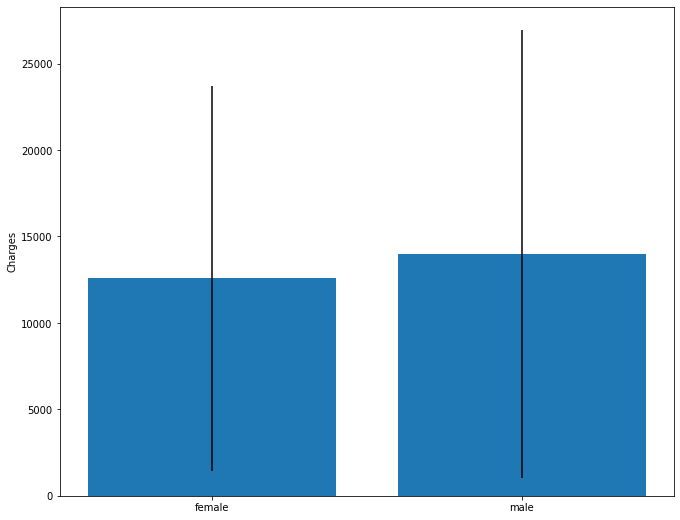

In [35]:
fig, ax = plt.subplots(figsize = (11,9))
ax.bar(x=grouped.index, height=grouped.charges['mean'], yerr=grouped.charges['std'])
ly = ax.set_ylabel("Charges")

In [36]:
insurance_data["sex"] = [1 if i == "male" else 0 for i in insurance_data["sex"] ]

In [37]:
insurance_data["log_charges"] = np.log(insurance_data.charges)

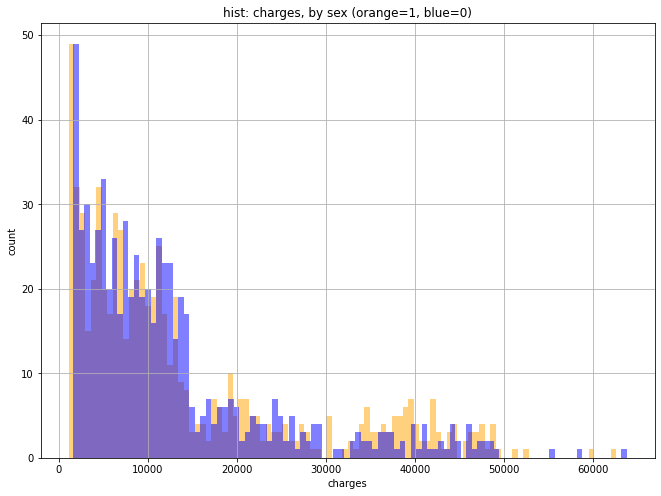

In [38]:
exploratory.feature_hist_by_class(eda_df=insurance_data,class_col="sex",feature="charges",bins=100)

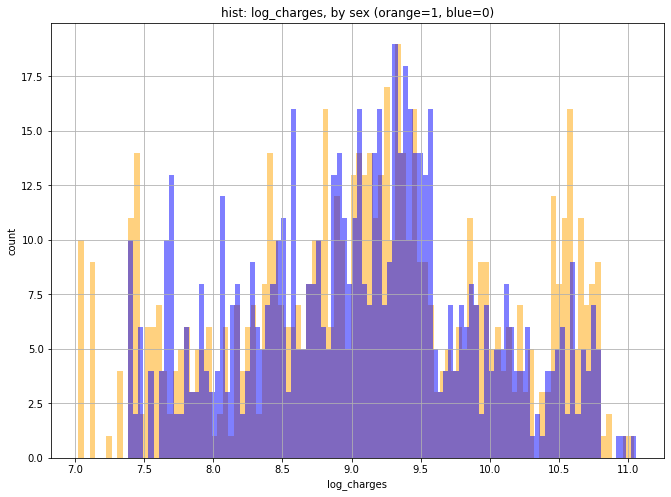

In [39]:
exploratory.feature_hist_by_class(eda_df=insurance_data,class_col="sex",feature="log_charges",bins=100)

#### 2.3 bmi

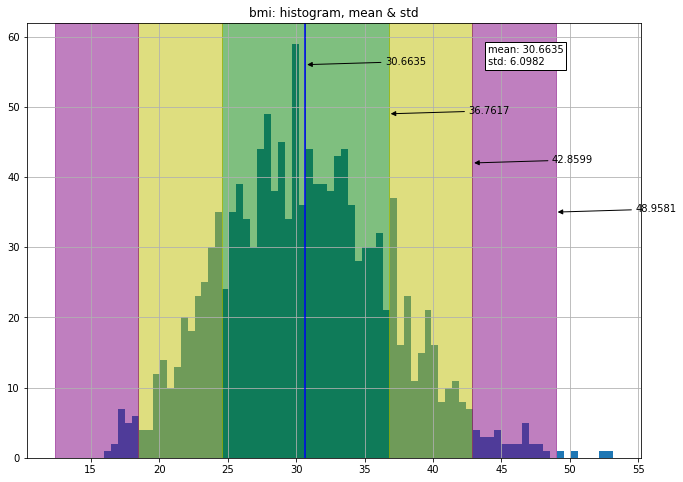

In [40]:
ax = exploratory.center_scale_plot(insurance_data.bmi, np.mean, np.std, bins=73)

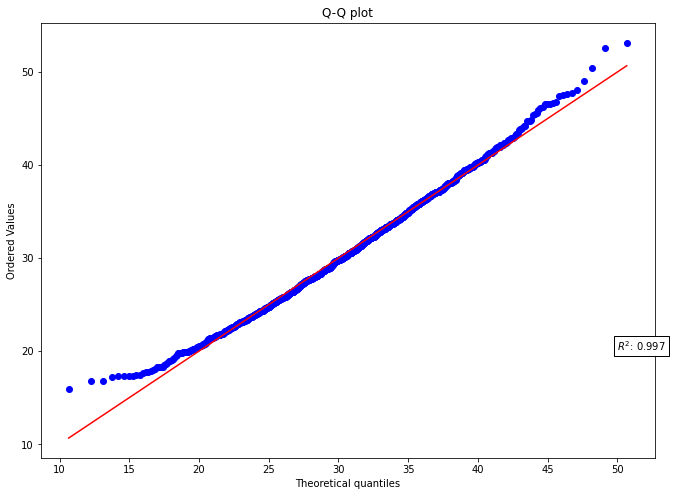

In [41]:
ax = exploratory.qq_plot(insurance_data.bmi)

**Notes:** 
- `bmi` is a measure of body fat based on height and weight that applies to adult men and women.
- The distribution of bmi is very similar to a normal distribution with a slightly skewness to the right

#### 2.4 Children

In [42]:
insurance_data.children.value_counts()

0    573
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [43]:
grouped = insurance_data[["children","charges"]].groupby("children").agg(['mean','std'])
grouped

charges              
                  mean           std
children                            
0         12384.695344  12025.424152
1         12731.171832  11823.631451
2         15073.563734  12891.368347
3         15355.318367  12330.869484
4         13850.656311   9139.223321
5          8786.035247   3808.435525

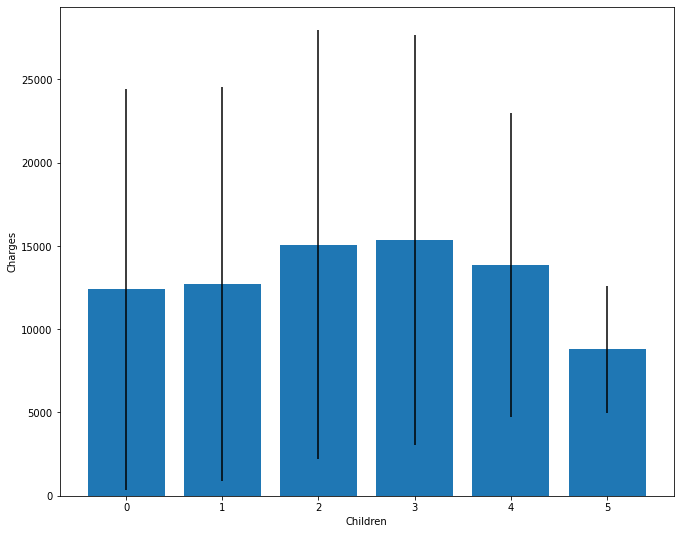

In [44]:
fig, ax = plt.subplots(figsize = (11,9))
ax.bar(x=grouped.index, height=grouped.charges['mean'], yerr=grouped.charges['std'])
l = ax.set_xlabel("Children")
ly = ax.set_ylabel("Charges")

#### 2.5 smoker

In [45]:
insurance_data.smoker.value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

In [46]:
insurance_data["smoker"] = [1 if i == "yes" else 0 for i in insurance_data["smoker"] ]

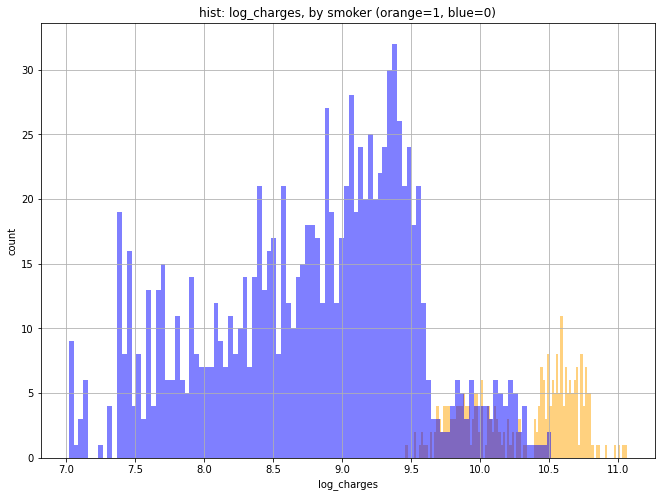

In [47]:
exploratory.feature_hist_by_class(eda_df=insurance_data,class_col="smoker",feature="log_charges",bins=100)

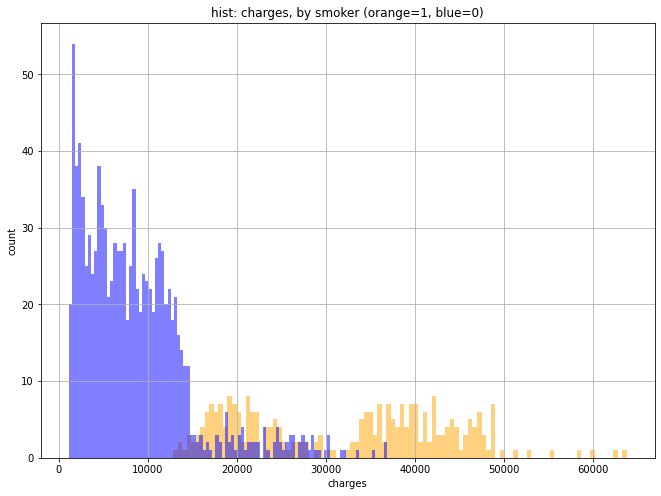

In [48]:
exploratory.feature_hist_by_class(eda_df=insurance_data,class_col="smoker",feature="charges",bins=100)

#### 2.6 region

In [49]:
insurance_data.region.value_counts()

southeast    364
southwest    325
northeast    324
northwest    324
Name: region, dtype: int64

In [50]:
grouped = insurance_data[["region","charges"]].groupby("region").agg(['mean','std'])
grouped

charges              
                   mean           std
region                               
northeast  13406.384516  11255.803066
northwest  12450.840844  11073.125699
southeast  14735.411438  13971.098589
southwest  12346.937377  11557.179101

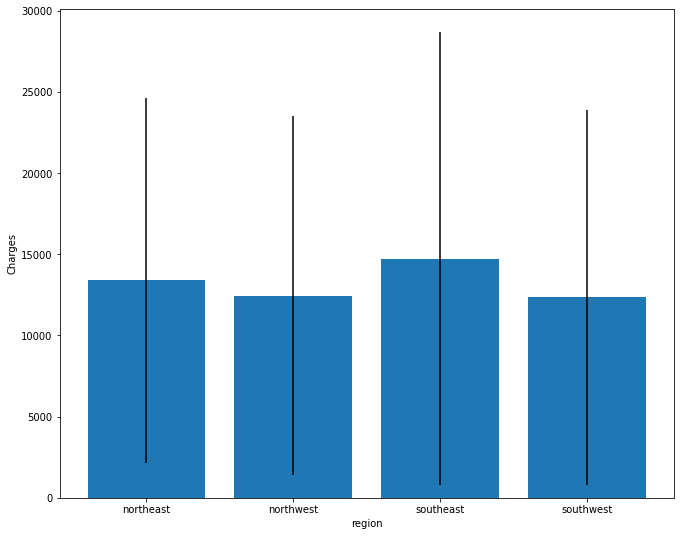

In [51]:
fig, ax = plt.subplots(figsize = (11,9))
ax.bar(x=grouped.index, height=grouped.charges['mean'], yerr=grouped.charges['std'])
lx = ax.set_xlabel("region")
ly = ax.set_ylabel("Charges")

#### 2.7 charge

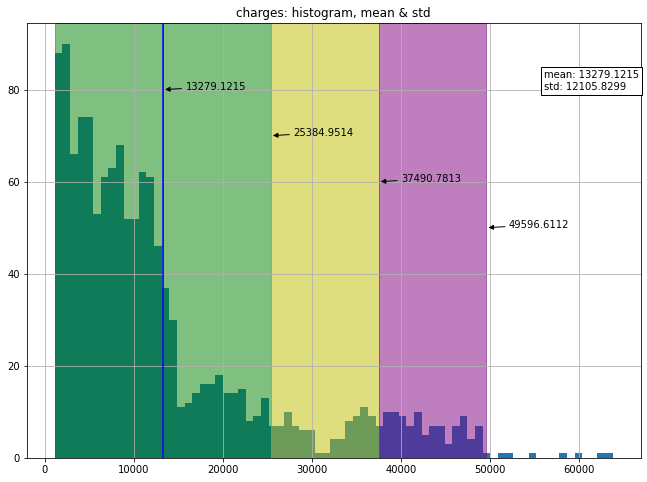

In [52]:
ax = exploratory.center_scale_plot(insurance_data.charges, np.mean, np.std, bins=73)

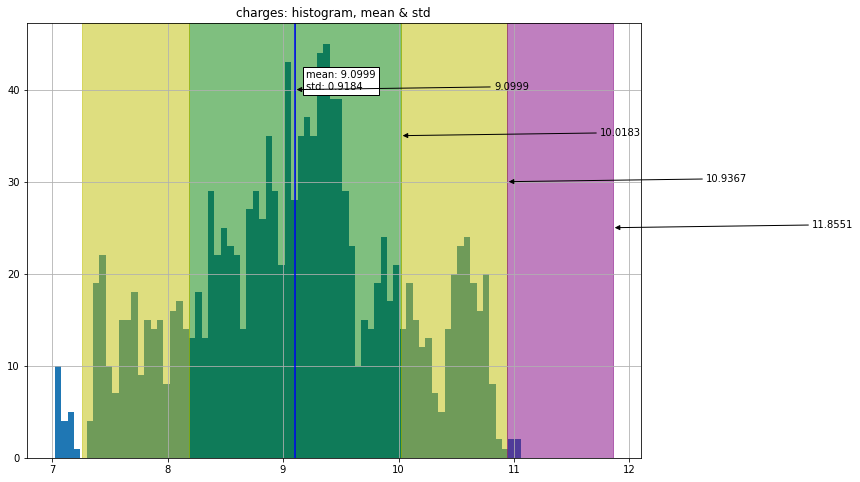

In [53]:
ax = exploratory.center_scale_plot(np.log(insurance_data.charges), np.mean, np.std, bins=73)

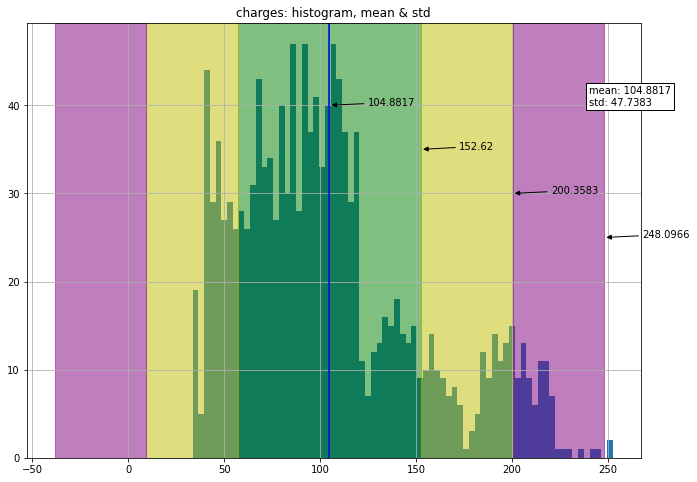

In [54]:
ax = exploratory.center_scale_plot(np.sqrt(insurance_data.charges), np.mean, np.std, bins=73)


**Notes**
Taking the log transform has yielded a more symmetrical dataset that sits almost entirely within 3 standard deviation bands.

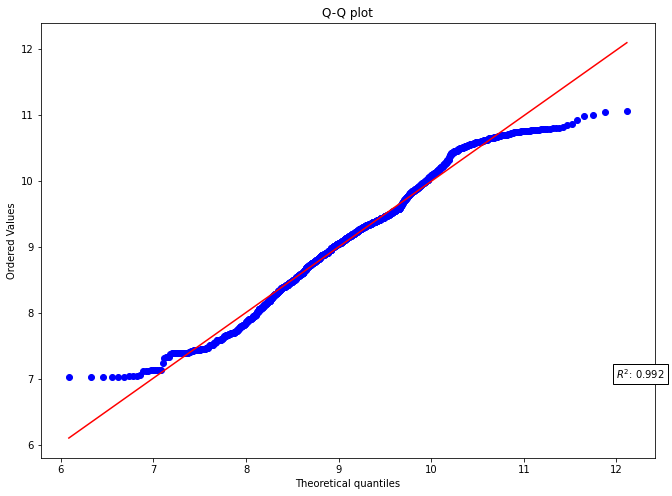

In [55]:
ax = exploratory.qq_plot(np.log(insurance_data.charges))

**Notes:** After the log transformation, the distribution of data is like normal distribution 

### 2. One hot encoding

In [56]:
def get_modeling_df(one_hot_cols, df):
    one_hot_df = []
    for col in one_hot_cols:
        temp = pd.get_dummies(df[col],prefix="is_{}".format(col),drop_first=True)
        one_hot_df.append(temp)
    one_hot_df = pd.concat(one_hot_df,axis=1)
    return pd.concat([df.drop(columns=one_hot_cols),one_hot_df], axis=1)

In [57]:
one_hot_cols = ['sex','smoker','region']
insurance_for_modeling = get_modeling_df(one_hot_cols, insurance_data)

In [58]:
insurance_for_modeling.dtypes

age                      int64
bmi                    float64
children                 int64
charges                float64
bmi_derivative         float64
log_charges            float64
is_sex_1                 uint8
is_smoker_1              uint8
is_region_northwest      uint8
is_region_southeast      uint8
is_region_southwest      uint8
dtype: object

### 3. Collinearity test

In [59]:
insurance_for_modeling.corr().style.background_gradient(cmap='coolwarm')

,age,bmi,children,charges,bmi_derivative,log_charges,is_sex_1,is_smoker_1,is_region_northwest,is_region_southeast,is_region_southwest
age,1.000000,0.109344,0.041536,0.298308,0.100680,0.526927,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109344,1.000000,0.012755,0.198401,0.991403,0.132822,0.046397,0.003746,-0.136138,0.270057,-0.006211
children,0.041536,0.012755,1.000000,0.067389,0.012401,0.160336,0.017848,0.007331,0.026044,-0.023492,0.021538
charges,0.298308,0.198401,0.067389,1.000000,0.192971,0.893084,0.058044,0.787234,-0.038695,0.073578,-0.043637
bmi_derivative,0.100680,0.991403,0.012401,0.192971,1.000000,0.124935,0.046287,0.007007,-0.143883,0.279168,-0.013128
log_charges,0.526927,0.132822,0.160336,0.893084,0.124935,1.000000,0.007009,0.665718,-0.015425,0.014968,-0.042473
is_sex_1,-0.019814,0.046397,0.017848,0.058044,0.046287,0.007009,1.000000,0.076596,-0.012482,0.017578,-0.003767
is_smoker_1,-0.025587,0.003746,0.007331,0.787234,0.007007,0.665718,0.076596,1.000000,-0.036321,0.068282,-0.037168
is_region_northwest,0.001495,-0.136138,0.026044,-0.038695,-0.143883,-0.015425,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
is_region_southeast,-0.012311,0.270057,-0.023492,0.073578,0.279168,0.014968,0.017578,0.068282,-0.345909,1.000000,-0.346614


**Notes:** 
    - `smoker` and `charges` have correlation of 0.782. They are highly correlated.
    - `bmi` and `charges` are also some how correlated (0.198)

#### Can also try `multicollinearity test`

### 4. Modeling - Ridge

In [60]:
X = insurance_for_modeling[[i for i in insurance_for_modeling.columns if 'charges' not in i]]

In [61]:
X.columns

Index(['age', 'bmi', 'children', 'bmi_derivative', 'is_sex_1', 'is_smoker_1',
       'is_region_northwest', 'is_region_southeast', 'is_region_southwest'],
      dtype='object')

In [62]:
y = insurance_for_modeling.log_charges

In [63]:
y.head()

0    9.734176
1    7.453302
2    8.400538
3    9.998092
4    8.260197
Name: log_charges, dtype: float64

In [64]:
ols = LinearRegressor()
ols.fit(X,y)
y_hat = ols.predict(y)
ols.r_sqrd()

0.7689293096703849

In [66]:
results = crossvalidate.cv_score(model_obj=RidgeRegressor(alpha=1),
                                 X=X,
                                 y=y,
                                 score_funcs=[r2_score])

In [67]:
results

mean       std
r2_score train  0.76043  0.004542
         test   0.75699  0.019356

In [68]:
alpha_l = np.linspace(np.power(0.1,6),np.power(10,6),11)
alpha_l

array([1.e-06, 1.e+05, 2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05,
       8.e+05, 9.e+05, 1.e+06])

#### `Sklearn`

In [69]:
# reg = LinearRegression().fit(X, y)

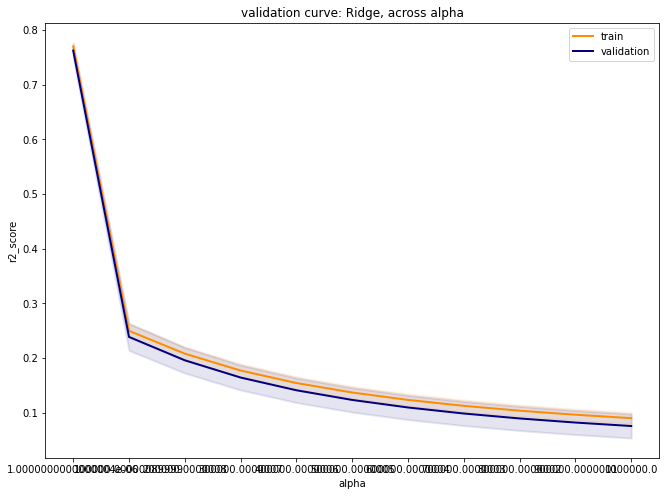

In [70]:
curves.validation_curve(model_type=Ridge,
                        X=X,
                        y=y,
                        param_name='alpha',
                        param_range=alpha_l,
                        score=r2_score, splits=3,random_state=1)

`Ours`

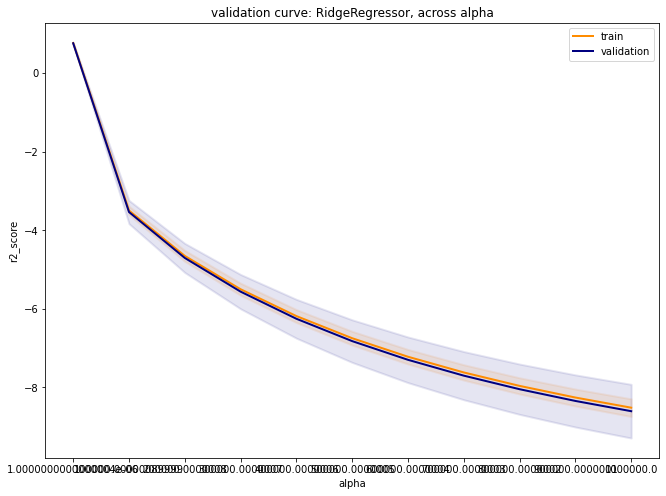

In [71]:
curves.validation_curve(model_type=RidgeRegressor,
                        X=X,
                        y=y,
                        param_name='alpha',
                        param_range=alpha_l,
                        score=r2_score,
                        splits=3,random_state=1)

**Notes**
- We are using `closed form linear algerba solution`. The result will break down at some degree. Not stable.
- We can explore more on the solver(e.g. Maximum likihood, gradiant decent) 


**Next Steps:**
- Find some real dataset with sources for debugging 
- Ticket on indoorplants: we need to expose the rot kwargs in `indoorplants`
- Evaluate the performance of Ridge with OLS
    - random state to be 0 
    - for small dataset, can pass in small splits in learning curve


## Test 3:  DOB data
- We are training on cross-sectional data: take 3 months of violation ecb data (so that other time factors) 
- take out issue date 
- then predict the `penalty amount`

In [7]:
import sqlite3
import sys
sys.path.insert(0, '../nyc_dob_violations/pydob/pydob')
import settings

In [8]:
def get_conn():
    return sqlite3.connect(DATABASE,
                           detect_types=sqlite3.PARSE_DECLTYPES |
                                        sqlite3.PARSE_COLNAMES
                        )

## 0 Get data

In [9]:
DATABASE = settings.DATABASE

In [10]:
vio_query = "select * from violations_ecb where issue_date_year = 2019 and issue_date_month >= 6 and issue_date_month <9"

In [11]:
query_sales = "select * from streeteasy_sales"

In [12]:
with get_conn() as conn:
    violations_ecb = pd.read_sql(vio_query, conn)
#     sales = pd.read_sql(query_sales, conn)

In [13]:
violations_ecb.shape

(24151, 52)

In [14]:
violations_ecb.issue_date.describe()

count                   24151
unique                     92
top       2019-07-17 00:00:00
freq                      520
first     2019-06-01 00:00:00
last      2019-08-31 00:00:00
Name: issue_date, dtype: object

### We are trying to predicting `Penalty_imposed` for 3 month of period 

In [15]:
violations_ecb.columns

Index(['isn_dob_bis_extract', 'ecb_violation_number', 'ecb_violation_status',
       'dob_violation_number', 'bin', 'boro', 'block', 'lot', 'hearing_date',
       'hearing_time', 'served_date', 'issue_date', 'severity',
       'violation_type', 'respondent_name', 'respondent_house_number',
       'respondent_street', 'respondent_city', 'respondent_zip',
       'violation_description', 'penality_imposed', 'amount_paid',
       'balance_due', 'infraction_code1', 'section_law_description1',
       'infraction_code2', 'section_law_description2', 'infraction_code3',
       'section_law_description3', 'infraction_code4',
       'section_law_description4', 'infraction_code5',
       'section_law_description5', 'infraction_code6',
       'section_law_description6', 'infraction_code7',
       'section_law_description7', 'infraction_code8',
       'section_law_description8', 'infraction_code9',
       'section_law_description9', 'infraction_code10',
       'section_law_description10', 'aggravate

In [16]:
violations_ecb.aggravated_level.unique()

array(['NO', 'AGGRAVATED OFFENSE LEVEL 1', 'AGGRAVATED OFFENSE LEVEL 2',
       None], dtype=object)

In [17]:
violations_ecb.certification_status.unique()

array(['N/A - DISMISSED', None, 'CERTIFICATE ACCEPTED',
       'NO COMPLIANCE RECORDED', 'CURE ACCEPTED', 'COMPLIANCE-INSP/DOC'],
      dtype=object)

In [18]:
df_sub = violations_ecb.loc[:,
    ["boro",
     "aggravated_level",
     "certification_status",
     "hearing_status",
     "penality_imposed",
     "violation_type","amount_paid"]]

In [19]:
df_sub.boro = df_sub.boro.astype("str")

In [20]:
cat_cols = ["boro","aggravated_level","certification_status","hearing_status","violation_type"]

In [21]:
for i in cat_cols:
    df_sub.loc[:,i] = df_sub[i].str.lower().str.replace(" ","_").str.replace("-","_").str.replace("/","_").str.replace("__","")

In [22]:
df_sub.certification_status.value_counts()

certificate_accepted      8382
no_compliance_recorded    6022
n_a_dismissed             4211
cure_accepted             2056
compliance_insp_doc         17
Name: certification_status, dtype: int64

In [23]:
df_sub.violation_type.unique()

array(['construction', 'unknown', 'elevators', 'quality_of_life',
       'site_safety', 'boilers', 'plumbing', 'zoning',
       'cranes_and_derricks', 'signs'], dtype=object)

In [24]:
df_sub.aggravated_level.unique()

array(['no', 'aggravated_offense_level_1', 'aggravated_offense_level_2',
       None], dtype=object)

In [25]:
df_sub.hearing_status.unique()

array(['dismissed', 'pending', 'default', 'in_violation', 'pop_in_vio',
       None, 'cured_in_vio', 'admit_in_vio', 'stipulation_in_vio'],
      dtype=object)

In [29]:
violations_for_modeling = get_modeling_df(cat_cols, df_sub)

In [31]:
violations_for_modeling.dtypes

penality_imposed                                  float64
amount_paid                                       float64
is_boro_2                                           uint8
is_boro_3                                           uint8
is_boro_4                                           uint8
is_boro_5                                           uint8
is_aggravated_level_aggravated_offense_level_2      uint8
is_aggravated_level_no                              uint8
is_certification_status_compliance_insp_doc         uint8
is_certification_status_cure_accepted               uint8
is_certification_status_n_a_dismissed               uint8
is_certification_status_no_compliance_recorded      uint8
is_hearing_status_cured_in_vio                      uint8
is_hearing_status_default                           uint8
is_hearing_status_dismissed                         uint8
is_hearing_status_in_violation                      uint8
is_hearing_status_pending                           uint8
is_hearing_sta

In [32]:
corr = violations_for_modeling.corr()

## 1 EDA

### y: `penality_imposed`

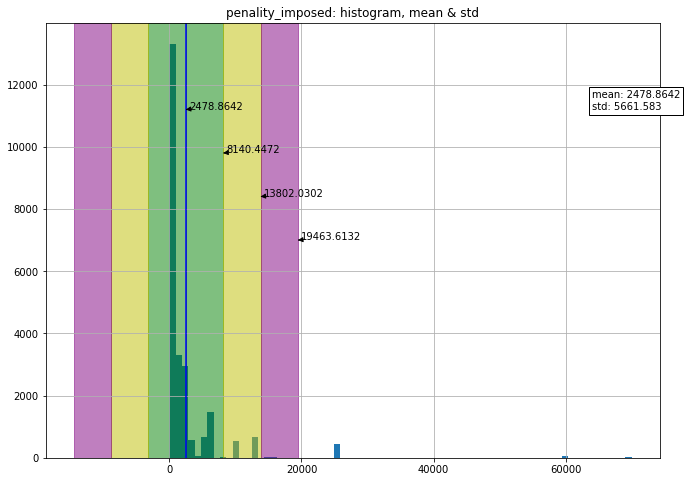

In [33]:
exploratory.center_scale_plot(violations_for_modeling.penality_imposed,np.mean, np.std, bins=73)

In [34]:
log_penalty = np.log(violations_for_modeling.loc[violations_for_modeling.penality_imposed > 0, "penality_imposed"])

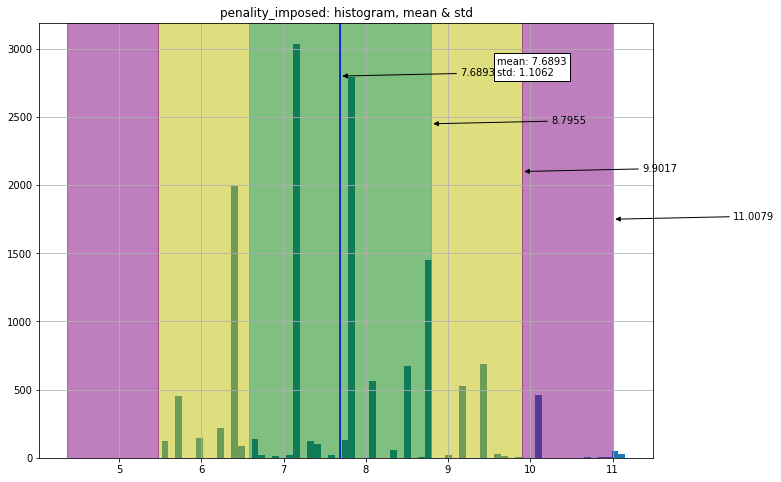

In [35]:
exploratory.center_scale_plot(log_penalty ,np.mean, np.std, bins=73)

In [36]:
X = violations_for_modeling[[i for i in violations_for_modeling.columns if 'penality_imposed' not in i]]

In [37]:
y = violations_for_modeling.penality_imposed

### Linear Regression

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [39]:
ours_ols = LinearRegressor()
ours_ols.fit(X_train,y_train)

In [40]:
y_hat = ours_ols.predict(y_test)

In [41]:
ours_ols.r_sqrd()

0.7108210247019092

### Ridge Regression

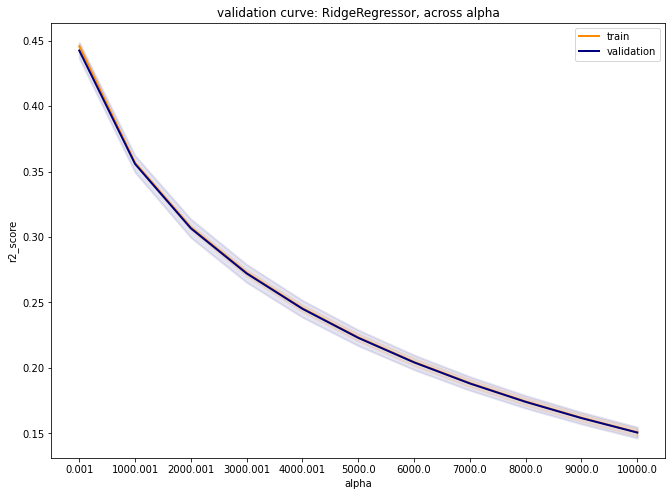

In [44]:
alpha_l = np.linspace(np.power(0.1,3),np.power(10,4),11).round(3)
curves.validation_curve(model_type=RidgeRegressor,
                        X=X,
                        y=y,
                        param_name='alpha',
                        param_range=alpha_l,
                        score=r2_score,
                        splits=3,random_state=1)

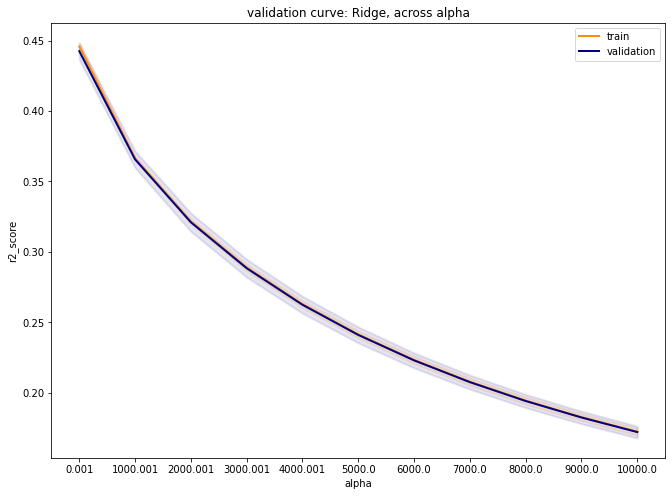

In [46]:
alpha_l = np.linspace(np.power(0.1,3),np.power(10,4),11).round(3)
curves.validation_curve(model_type=Ridge,
                        X=X,
                        y=y,
                        param_name='alpha',
                        param_range=alpha_l,
                        score=r2_score,
                        splits=3,random_state=1)